# Data Prep

In [1]:
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

(<Axes: >, <Axes: >)

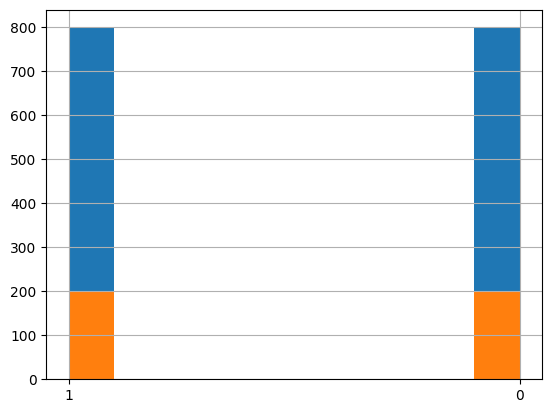

In [2]:
df = pd.read_csv("images/data.csv", sep="\t")
df.tortuous = df.tortuous.astype(str)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.tortuous)
train_df.tortuous.hist(), test_df.tortuous.hist()

In [3]:
BATCH_SIZE = 4
IMG_SIZE = 244
NUM_CLASSES = train_df["tortuous"].nunique()

In [4]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = "tortuous",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    test_df,
    x_col = "filename",
    y_col = "tortuous",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [5]:
classes = train_df["tortuous"].unique()

In [6]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(training_generator.classes), 
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 1.0, 1: 1.0}

# Gradcam

In [7]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [8]:
@tf.function
def compute_gradcam_map(model, image, eps=1e-8):    
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap

In [9]:
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []

In [10]:
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)

    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)    
    return tf.multiply(pool_binary_masks, imgs)

In [11]:
@tf.function
def generate_gradcam_batch_withheat(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)
    
    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)
    return fused_heatmaps, pool_binary_masks, tf.multiply(pool_binary_masks, imgs)

In [12]:
def overlay_heatmap(heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

# Train Global branch - CustomModel

In [13]:
def build_custom_model():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [14]:
global_model = build_custom_model()

In [15]:
global_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [16]:
global_model.load_weights("models_tf/43_0.364_0.950.h5")

In [ ]:
EPOCHS = 100

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_tf/{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True )
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]
mycallbacks = [learning_rate_reduction, checkpoint] # disable early stop

In [ ]:
history = global_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
)

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
val_loss, val_accuracy = global_model.evaluate(val_generator)
print(val_loss, val_accuracy)

e:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


100/100 [==============================] - 9s 40ms/step - loss: 0.0845 - accuracy: 0.9900
0.08453471213579178 0.9900000095367432


In [ ]:
global_model.save_weights(f"models_tf/100_{val_loss:.3f}_{val_accuracy:.3f}.h5")

# Visualize GradCAM

In [18]:
images, labels = training_generator.next()

In [19]:
print(tf.argmax(labels, axis=1))

tf.Tensor([0 1 0 0], shape=(4,), dtype=int64)


In [20]:
heatmaps, masks, masked_images = generate_gradcam_batch_withheat(images, global_model, 0.75)

In [21]:
overlaid_images = [overlay_heatmap(hmap.numpy(), img, alpha=0.8) for (hmap, img) in zip(heatmaps, images)]

In [22]:
print(tf.argmax(labels, axis=1))
print(tf.argmax(global_model(tf.convert_to_tensor(images)), axis=1))

tf.Tensor([0 1 0 0], shape=(4,), dtype=int64)
tf.Tensor([0 1 0 0], shape=(4,), dtype=int64)


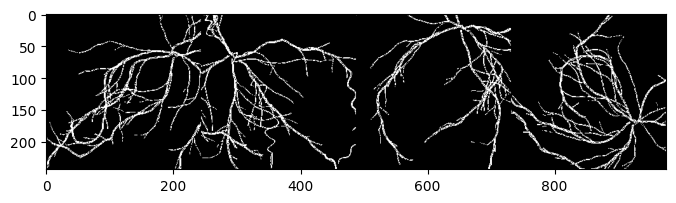

In [23]:
# Input images
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(images), cmap="jet")

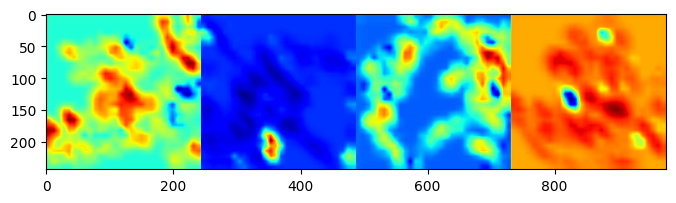

In [24]:
# Attention maps
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in heatmaps]), cmap="jet")

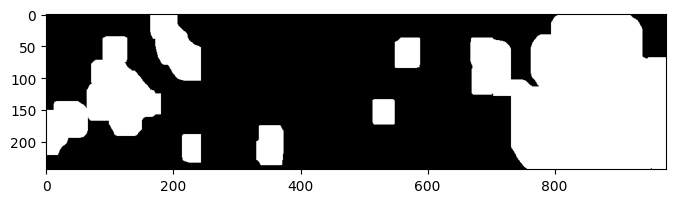

In [25]:
# Masks
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in masks]), cmap="jet")

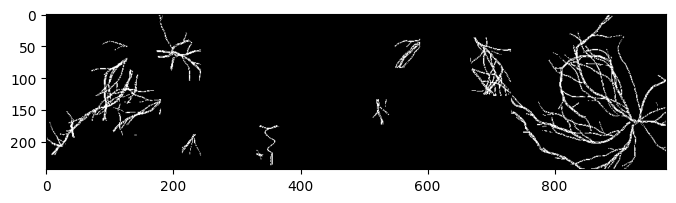

In [26]:
# Local input
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(masked_images), cmap="jet")

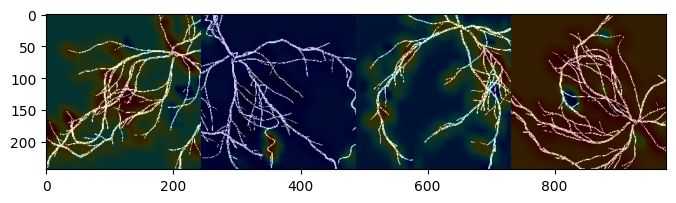

In [27]:
# Overlaid
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(overlaid_images), cmap="jet")

In [ ]:
OUTPUT_FOLDER = "GradCAM_Outputs"
!mkdir "$OUTPUT_FOLDER"

In [ ]:
IMAGE_START = 0

In [ ]:
!mkdir "$OUTPUT_FOLDER/images"
for img_id, (img, label) in enumerate(zip(images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/images/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/gradcams"
for img_id, (img, label) in enumerate(zip(heatmaps, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/gradcams/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/overlaid"
for img_id, (img, label) in enumerate(zip(overlaid_images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/overlaid/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/masks"
for img_id, (img, label) in enumerate(zip(masks, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/masks/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", np.asarray(img), cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/masked_images"
for img_id, (img, label) in enumerate(zip(masked_images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/masked_images/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", np.asarray(img), cmap="jet")

# Metrics

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [29]:
def get_metrics(prediction_function):
    y_pred = []
    y_pred_max = []
    y_true = []

    num_steps = val_generator.samples//BATCH_SIZE

    for i in range(num_steps):
        print(f"\r{i}/{num_steps}", end="")
        x, y = val_generator.next()
        y_pred_batch = prediction_function(x, y)
        y_pred += list(y_pred_batch.numpy())
        y_pred_max += list(tf.argmax(y_pred_batch, axis=1).numpy())
        y_true += list(tf.argmax(y, axis=1).numpy())
    
    print()
    acc = accuracy_score(y_true, y_pred_max)
    print("Accuracy: ", acc)
    
    bacc = balanced_accuracy_score(y_true, y_pred_max)
    print("Balanced Accuracy: ", bacc)
    
    precision = precision_score(y_true, y_pred_max, average='weighted')
    print("Precision: ", precision)
    
    recall = recall_score(y_true, y_pred_max, average='weighted')
    print("Recall: ", recall)
    
    f1 = f1_score(y_true, y_pred_max, average='weighted')
    print("F1: ", f1)

    auc = roc_auc_score(y_true, y_pred_max, average='weighted', multi_class='ovr')
    print("AUC: ", auc)

In [30]:
def pred_global(images, labels):
    return global_model(images, training=False)

In [31]:
get_metrics(pred_global)

99/100
Accuracy:  0.99
Balanced Accuracy:  0.99
Precision:  0.99
Recall:  0.99
F1:  0.99
AUC:  0.99
